# 模型选择

目录

- 欠拟合和过拟合
- 权重衰减
- 暂退法（Dropout）

## 欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.7135],
         [0.4976]]),
 tensor([[1.0000e+00, 7.1346e-01, 2.5451e-01, 6.0527e-02, 1.0796e-02, 1.5405e-03,
          1.8318e-04, 1.8670e-05, 1.6650e-06, 1.3199e-07, 9.4170e-09, 6.1079e-10,
          3.6314e-11, 1.9930e-12, 1.0156e-13, 4.8308e-15, 2.1541e-16, 9.0403e-18,
          3.5833e-19, 1.3455e-20],
         [1.0000e+00, 4.9764e-01, 1.2382e-01, 2.0540e-02, 2.5554e-03, 2.5434e-04,
          2.1095e-05, 1.4997e-06, 9.3288e-08, 5.1582e-09, 2.5670e-10, 1.1613e-11,
          4.8160e-13, 1.8436e-14, 6.5531e-16, 2.1741e-17, 6.7620e-19, 1.9794e-20,
          5.4725e-22, 1.4334e-23]]),
 tensor([5.3958, 5.5251]))

实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.9961076  1.1977049 -3.383854   5.6232586]]


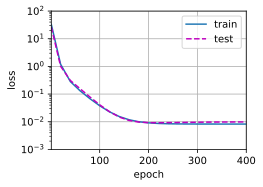

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.1164684 4.298125 ]]


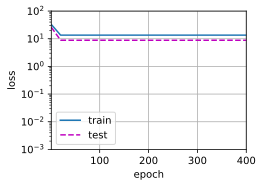

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.99766     1.2872416  -3.3798084   5.19445    -0.01223703  1.1709547
   0.18639933 -0.03800117  0.22357842 -0.19907166 -0.04570822 -0.11779588
   0.01551174  0.08947276  0.10764467  0.2204279  -0.15191121 -0.09354579
  -0.12271424 -0.10525914]]


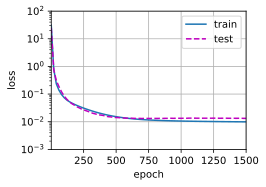

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## 权重衰减

权重衰减是最广泛使用的正则化的技术之一

In [9]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

像以前一样生成一些数据
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$

In [10]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数。注意：$w$的标准差异常高，容易导致优化问题

In [11]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义$L_2$范数惩罚

In [12]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

定义训练代码实现

In [13]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)  # 增加了L2范数惩罚项
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

忽略正则化直接训练。非常典型的欠拟合：训练误差还在下降阶段

w的L2范数是： 13.431254386901855


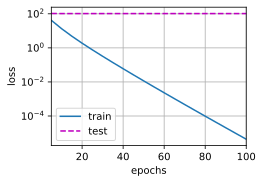

In [14]:
train(lambd=0)

使用权重衰减。测试误差仍在下降阶段。

w的L2范数是： 0.3891151249408722


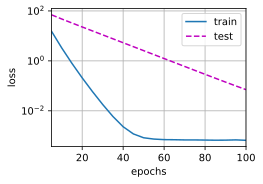

In [15]:
train(lambd=3)

简洁实现

In [16]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_() # 默认值恰好是(mean=0, std=1)
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这些图看起来与之前类似。但训练误差更快趋向水平：库函数有内部优化

w的L2范数： 14.588664054870605


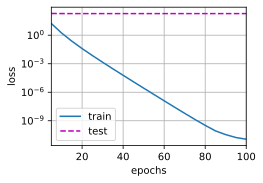

In [17]:
train_concise(0)

w的L2范数： 0.373628705739975


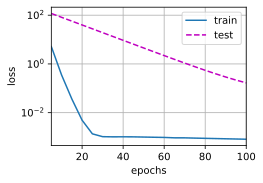

In [18]:
train_concise(3)

## 暂退法（Dropout）

In [19]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    """以`dropout`的概率丢弃张量输入`X`中的元素"""
    assert 0 <= dropout <= 1
    if dropout == 1:  # 在本情况中，所有元素都被丢弃
        return torch.zeros_like(X)
    if dropout == 0:  # 在本情况中，所有元素都被保留
        return X
    # 为什么要掩码？并行计算两个分支
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

测试`dropout_layer`函数

In [20]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8., 10.,  0., 14.],
        [ 0.,  0.,  0.,  0., 24.,  0.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [21]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:  # 只有在训练模型时才使用dropout
            H1 = dropout_layer(H1, dropout1)  # 在第一个全连接层之后添加一个dropout层
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2, dropout2)  # 在第一个全连接层之后添加一个dropout层
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

训练和测试

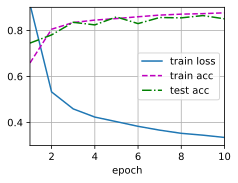

In [22]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

简洁实现

In [23]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),  # 在第一个全连接层之后添加一个dropout层
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),  # 在第二个全连接层之后添加一个dropout层
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

对模型进行训练和测试

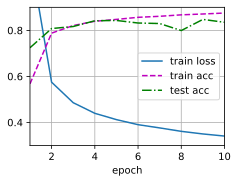

In [24]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)